En este notebook se pretende implementar un encoder siguiendo los algoritmos propuestos en word2vec. Par ello tenemos en cuenta las siguientes referencias:
- https://arxiv.org/abs/1301.3781
- https://arxiv.org/pdf/1310.4546
- https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial
- https://jaketae.github.io/study/word2vec/
- https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
- https://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/
- https://towardsdatascience.com/implementing-word2vec-in-pytorch-from-the-ground-up-c7fe5bf99889/
- https://github.com/JonahBreslow/Word2Vec-PyTorch/blob/main/README.md
- https://gist.github.com/JonahBreslow/8b6f0e91fcbdfb449798708a53f4656e
- https://medium.com/@sybil.wangmh/word2vec-model-structure-and-python-implementation-bda6cdda24d9
- https://github.com/giuseppefutia/word2vec

Tenía problemas de compatibilidad entre torch y torchtext

Para solucionarlo cree este entocno virtual e instale versiones copatibles entre si

Utilicé el utlimo comando de la siguiente celda para ligar este entono y este jupyter notebook

python3 -m venv .venv

source .venv/bin/activate

pip install --upgrade pip                   

pip install \
  torch==2.3.1 \
  torchvision==0.18.1 \
  torchaudio==2.3.1 \
  torchtext==0.18.0
  torchdata==0.7.1

pip install datasets

pip install 'portalocker>=2.0.0'

pip install jupyter        

python -m ipykernel install --user --name word2vec-env --display-name "Python (word2vec)"

# IMPORTACION DE LIBRERÍAS

In [1]:
import re
import random
import math
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import sklearn

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torchtext.datasets import WikiText2

import os

from datasets import load_dataset

import mlflow
import time
import json
from pathlib import Path
from datetime import datetime




/Volumes/SSD_ROQUE/proyectos didacticos/word2vec /.venv/lib/python3.11/site-packages/torchtext/datasets/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/Volumes/SSD_ROQUE/proyectos didacticos/word2vec /.venv/lib/python3.11/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


# INTENTO DE DESACARGAR EL DATASET CON TORCHTEXT

In [2]:
# cargar el dataset wiki2 en mi SSD
# os.environ["TORCH_HOME"] = "/Volumes/SSD_ROQUE/torch_cache"

In [3]:
# ROOT = "/Volumes/SSD_ROQUE/torch_cache/text_datasets"
# train_iter = WikiText2(root=ROOT, split="train")# Descargar el dataset si no está disponible
# text = " ".join(train_iter)             # un solo string grande
# len(text)


In [4]:
# rm -f "/Volumes/SSD_ROQUE/torch_cache/text_datasets/datasets/WikiText2/wikitext-2-v1.zip" # BORRAR ALGO ANTERIOR
# rm -rf "/Volumes/SSD_ROQUE/torch_cache/text_datasets/datasets/WikiText2/wikitext-2" # BORRAR ALGO ANTERIOR
# mkdir -p "/Volumes/SSD_ROQUE/torch_cache/text_datasets/datasets/WikiText2" #CREAR CARPETA POR SI NO EXISTE
# curl -L --retry 5 --retry-delay 2 \
#  -o "/Volumes/SSD_ROQUE/torch_cache/text_datasets/datasets/WikiText2/wikitext-2-v1.zip" \
#  "https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip" # DESCARGAR DATASET A MANO

In [5]:
# import os
# print("TORCH_HOME env:", os.environ.get("TORCH_HOME"))
# print("HOME:", os.path.expanduser("~"))

# DESCARGAR EL DATASET DE HUGGING FACE

In [6]:
# reproducibilidad
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
CACHE_DIR = "/Volumes/SSD_ROQUE/hf_datasets" # carpeta en mi SSD para datasets de Hugging Face
ds = load_dataset("Salesforce/wikitext", "wikitext-2-v1", cache_dir=CACHE_DIR) # cargar dataset desde Hugging Face
train_lines = ds["train"]["text"] # obtener las líneas de texto del conjunto de entrenamiento
len(train_lines), train_lines[3] # número de líneas y primera línea del conjunto de entrenamiento

(36718,
 ' Senjō no Valkyria 3 : <unk> Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . <unk> the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " <unk> Raven " . \n')

# PREPARACION DE LOS DATOS

## LIMPIEZA Y TOKENIZACIÓN

En Word2Vec no se trabaja con frases ni signos, sino con una secuencia plana de tokens:
['en','ocasiones','veo','muertos']

Por tanto, se eliminan:
- puntuación (.,;:!?)
- símbolos (=, $, %, @)
- saltos de línea
- marcas raras de WikiText (= =, ==, etc.)

Y se decide:
- minúsculas sí/no → sí (estándar)
- números → normalmente se eliminan
- tokens muy raros → se filtran luego con min_count

Word2Vec clásico:
- lowercasing
- tokenización por palabras
- no lematiza
- no elimina stopwords
- elimina palabras raras por frecuencia (min_count)
- usa subsampling (luego)

👉 Nada de NLP avanzado. Es importante: el modelo aprende estadísticamente.

**Tokenización correcta para WikiText2**

WikiText tiene:
- encabezados tipo = Introduction =
- tokens raros como @-@
- muchos signos

Reglas razonables:
- solo letras (a–z)
- longitud ≥ 2 (opcional)
- todo en minúsculas

1️⃣ Limpieza del texto (qué conservamos)

El primer paso en la preparación de datos para **Word2Vec** es limpiar el texto y quedarnos únicamente con **palabras**.

- Se eliminan signos de puntuación, símbolos, números y marcas especiales.
- Todas las palabras se convierten a minúsculas.
- No se eliminan *stopwords* (palabras funcionales como *the*, *of*, *to*), ya que Word2Vec las gestiona mediante *subsampling*.

El objetivo es obtener una **secuencia plana de tokens léxicos**.

---

2️⃣ Tokenización por palabras

La tokenización se realiza extrayendo únicamente secuencias alfabéticas (`a–z`), ignorando cualquier otro carácter.

3️⃣ Generación del flujo de tokens

Una vez definida la tokenización, el corpus completo se transforma en un **flujo continuo de tokens**:

- Se recorren todas las líneas del conjunto de entrenamiento.
- Cada línea se tokeniza de forma independiente.
- Los tokens se concatenan en una única secuencia ordenada.

El resultado es una lista (o iterador) de palabras que representa el corpus completo y que servirá como entrada para:
- el conteo de frecuencias,
- la construcción del vocabulario,
- y el entrenamiento del modelo *Skip-gram*.

In [8]:
# 2) Tokenización "solo palabras": minúsculas + letras a-z
WORD_RE = re.compile(r"[a-z]+")

def tokenize_line(line: str):
    return WORD_RE.findall(line.lower())

def iter_tokens(lines):
    for line in lines:
        for tok in tokenize_line(line):
            yield tok

# 3) Obtener una lista de tokens
tokens = list(iter_tokens(train_lines))

print("n_lines:", len(train_lines))
print("n_tokens:", len(tokens))
print("sample:", tokens[:30])

n_lines: 36718
n_tokens: 1694562
sample: ['valkyria', 'chronicles', 'iii', 'senj', 'no', 'valkyria', 'unk', 'chronicles', 'japanese', 'lit', 'valkyria', 'of', 'the', 'battlefield', 'commonly', 'referred', 'to', 'as', 'valkyria', 'chronicles', 'iii', 'outside', 'japan', 'is', 'a', 'tactical', 'role', 'playing', 'video', 'game']


1) WORD_RE = re.compile(r"[a-z]+")

Qué es
- re.compile(...) crea un objeto regex (expresión regular) ya “preparado”.
- r"[a-z]+" significa:
- [a-z] = una letra minúscula de la a a la z
- + = “una o más” letras seguidas

Por tanto, detecta secuencias de letras.

Ejemplos
- "hello" → ["hello"]
- "it's" → ["it", "s"] (porque el apóstrofe corta)
- "U.S.A." → ["u", "s", "a"] (tras minúsculas, y los puntos cortan)
- "2024" → [] (no hay letras)
- "co-operate" → ["co", "operate"] (el guion corta)

Por qué lo hacemos así

En Word2Vec “clásico” interesa un preprocesado mínimo y estable:
- Reducir ruido de símbolos raros
- Evitar que @-@ (muy típico en WikiText) se convierta en tokens “raros”
- Mantener un vocabulario más limpio y manejable

## FILTRADO 

- Ahora se van a eliminar palabras que aparezacan muy pocas veces. Esto se ahce por que pueden ser nrombres propios, erroreres tipográficos y demás que consumiran recursos y como aparecen pocas veces su significado no llegará a codificarse de formacorrecta

- Subsampling: Tambien se "eliminarán" algunas apariciones de palabras muy frecuentes (a, el the, of...), para no malgastar computación en ese tipo de palabras. Además así no se da tanata importancia a este tipo de palabras sin 'carga semántica' y se focaliza el modelo en aquellas palabras con 'significado fuerte'. Para esto se hace uso de la formula que aparece en el paper, $P(\text{keep}(w)) = \min\left(1,\ \sqrt{\frac{t}{f(w)}} + \frac{t}{f(w)}\right)$, donde $f(w)$ es la frecuenci relativa del token $w$ y t es el umbral de subsampling (típicamente $10^{-5}$ )

In [9]:
# Contar frecuencias
counts = Counter(tokens)
total_tokens = sum(counts.values())

# Umbral mínimo
min_count = 5

# Filtrado del volcabulario
vocab = [w for w, c in counts.items() if c >= min_count]
vocab.sort()

# Mapas
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}

print("Vocab size:", len(vocab))
print("Ejemplo vocab:", vocab[:20])

Vocab size: 19408
Ejemplo vocab: ['a', 'aa', 'aaa', 'aadt', 'aak', 'aaknal', 'aaron', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abbey', 'abbot', 'abbott', 'abbreviations', 'abby', 'abc', 'abd', 'abdication', 'abdomen']


In [10]:
# Frecuencia relativa
freq = {w: counts[w] / total_tokens for w in vocab}

# Parámetro arbitrario de umbral
t = 1e-5

def keep_word(word):
    f = freq[word]
    p_keep = math.sqrt(t / f) + (t / f)
    p_keep = min(1.0, p_keep)
    return random.random() < p_keep

In [11]:
corpus = [
    word2idx[w]
    for w in tokens
    if w in word2idx and keep_word(w)
]

print("Corpus length after subsampling:", len(corpus))
print("Sample ids:", corpus[:20])

Corpus length after subsampling: 507658
Sample ids: [18440, 3011, 8515, 15619, 18440, 3011, 10193, 18440, 1543, 18440, 3011, 9260, 17200, 15015, 13149, 15570, 18678, 13298, 9260, 18440]


In [12]:
# Comparar antes vs después
print("Antes:", len(tokens))
print("Después:", len(corpus))

Antes: 1694562
Después: 507658


# PREPARACION NEGATIVE SAMPLING

## Motivación

Word2Vec quiere modelar la probabilidad de que una palabra de contexto $c$ aparezca cerca de una palabra central $w$.

La formulación directa usa un softmax sobre todo el vocabulario:

$P(c \mid w) = \frac{e^{v_c^\top u_w}}{\sum_{c' \in V} e^{v_{c'}^\top u_w}}$

Esto es computacionalmente inviable porque el vocabulario puede tener decenas o cientos de miles de palabras.

Negative sampling es una aproximación eficiente que evita este coste.

---

## Idea central

En lugar de preguntar:

- ¿Cuál de TODAS las palabras es el contexto correcto?

se pregunta:

- ¿Este par palabra–contexto es real o falso?

El problema se convierte en uno de **clasificación binaria**.

---

## Ejemplos positivos y negativos

- Ejemplo positivo: un par real observado en el corpus  
  - $(w = \text{"cat"},\ c = \text{"sat"})$

- Ejemplo negativo: un par generado artificialmente  
  - $(w = \text{"cat"},\ c = \text{"banana"})$

Los ejemplos negativos se muestrean aleatoriamente del vocabulario.

---

## Qué aprende el modelo

Para cada palabra central $w$:

- se toma un contexto real $c^+$
- se generan $k$ contextos falsos $c_1^-, \dots, c_k^-$
- el modelo aprende a:
  - asignar probabilidad alta a $(w, c^+)$
  - asignar probabilidad baja a $(w, c^-)$

---

## Función objetivo

Se utiliza la función sigmoide:

$\sigma(x) = \frac{1}{1 + e^{-x}}$

La contribución de un par positivo es:

$\log \sigma(v_{c^+}^\top u_w)$

La contribución de un par negativo es:

$\log \sigma(-v_{c^-}^\top u_w)$

La pérdida total para una palabra central es:

$\log \sigma(v_{c^+}^\top u_w) + \sum_{i=1}^k \log \sigma(-v_{c_i^-}^\top u_w)$

---

## Interpretación geométrica

- Si $v_c^\top u_w$ es grande y positivo:
  - los vectores están alineados
  - las palabras están relacionadas

- Si $v_c^\top u_w$ es negativo:
  - los vectores se separan
  - las palabras no están relacionadas

Negative sampling organiza el espacio de embeddings empujando:
- pares reales a acercarse
- pares falsos a separarse

---

## Distribución para muestrear negativos

Los negativos no se muestrean de forma uniforme:
- muestrea demasiadas palabras raras
- poco informativo

Tamopco con la empirica $f(w)$:
- demasiadas spotwords


Se usa la distribución propuesta por Mikolov en el paper:

$P(w) \propto f(w)^{3/4}$

donde $f(w)$ es la frecuencia empírica de la palabra.

Esto:
- reduce la dominancia de stopwords
- aumenta la probabilidad de palabras de frecuencia media
- mejora la calidad del embedding

---

## Número de negativos

Valores típicos:
- corpus pequeño: $k = 5$
- corpus grande: $k = 10$–$20$

Más negativos implican:
- mejor aproximación
- mayor coste computacional

---

## Resumen conceptual

- Word2Vec no aprende probabilidades exactas
- aprende a distinguir señal de ruido
- el significado emerge de la estructura de co-ocurrencias

Negative sampling permite entrenar Word2Vec de forma eficiente y escalable.

# CÓDIGO NEGATIVE SAMPLING

### PREPARAR DISITRIBUCIÓN

In [13]:
# 1) Construir distribución de muestreo para negativos: P(w) ∝ f(w)^(3/4)
power = 0.75

# freqs[i] = conteo de la palabra cuyo id es i
freqs = torch.zeros(len(word2idx), dtype=torch.float)

# counts contiene conteos sobre tokens "antes" del subsampling (lo normal)
# OJO: aseguramos que solo metemos palabras que están en vocab/word2idx
for w, idx in word2idx.items():
    freqs[idx] = counts[w] # las veces que aparece el token w, con índice idx

neg_dist = freqs ** power # se eleva a la potencia deseada, en este caso 3/4
neg_dist /= (0.03+neg_dist.sum()) # normalizar a 1

print("neg_dist shape:", neg_dist.shape)
print("neg_dist sum:", float(neg_dist.sum()))

neg_dist shape: torch.Size([19408])
neg_dist sum: 0.9999999403953552


### MUESTREAR

In [14]:
def sample_negatives(neg_dist, batch_size, num_negatives, device=None):
    """
    Devuelve un tensor (B, K) con ids de palabras negativas muestreadas
    según neg_dist (P(w) ∝ f(w)^(3/4)).
    
    Args:
        neg_dist: torch.Tensor con distribución de muestreo (vocab_size,)
        batch_size: número de ejemplos en el batch (B)
        num_negatives: número de negativos por ejemplo (K)
        device: dispositivo donde colocar el tensor resultante , 'cpu' o'cuda'
    """
    neg = torch.multinomial(# muestrear con reemplazo, índices enteros en [0, V-1]
        neg_dist, # la probabilidad de muestreo de cada indicie viene dada por neg_dist
        num_samples=batch_size * num_negatives, # numero de muestras
        replacement=True # si hay o no remplazamiento
    ).view(batch_size, num_negatives)# reshape a (B, K)

    if device is not None: # mover a dispositivo
        neg = neg.to(device)
    return neg

In [15]:
# ejemplo
B = 8
K = 5
neg = sample_negatives(neg_dist, B, K)
neg, neg.shape

(tensor([[  800,   903,  2042,   670, 10800],
         [ 9720, 18843, 18286,  1186,  2278],
         [ 2759,  7767, 17464, 17513,  7840],
         [12255,  1294, 14387, 12464,  8890],
         [ 1028, 13960,  6560,  6491,   501],
         [  629, 18356,  2639,  5439,  2218],
         [ 5112,  4611,  4415,  6647, 12275],
         [12130, 17467,   511,  6495,  8733]]),
 torch.Size([8, 5]))

In [16]:
def sample_negatives_avoid_pos(neg_dist, pos, num_negatives, device=None):
    """
    Devuelve un tensor (B, K) con ids de palabras negativas muestreadas
    según neg_dist (P(w) ∝ f(w)^(3/4)).
    
    Args:
        neg_dist: torch.Tensor con distribución de muestreo (vocab_size,)
        pos: tensor (B,) con ids de palabras positivas a evitar
        num_negatives: número de negativos por ejemplo (K)
        device: dispositivo donde colocar el tensor resultante , 'cpu' o'cuda'
    """
    
    B = pos.size(0)
    
    neg = torch.multinomial(# muestrear con reemplazo, índices enteros en [0, V-1]
        neg_dist, # la probabilidad de muestreo de cada indicie viene dada por neg_dist
        num_samples=B * num_negatives,# numero de muestras
        replacement=True  # si hay o no remplazamiento
    ).view(B, num_negatives) # reshape a (B, K)

    # Re-muestreo simple donde neg == pos
    mask = neg.eq(pos.unsqueeze(1)) # (B, K) máscara de donde hay conflicto ( neg==pos)
    # pos.unsqueeze(1) lo convierte en (B, 1) para poder compararlo con (B, K) por broadcasting
    # compara pos[i] contra cada neg[i, j]
    # neg.eq(...) devuelve un boolean tensor:
	#	mask.shape == (B, K)
	#	mask[i, j] == True si neg[i, j] == pos[i]
	#	mask[i, j] == False si neg[i, j] != pos[i]
    
    while mask.any(): # mask.any() devuelve True si existe al menos un True en toda la matriz
        
        neg[mask] = torch.multinomial(neg_dist, mask.sum().item(), replacement=True) # esta línea “repara” exactamente las posiciones problemáticas
	#   mask.sum() cuenta cuántos True hay (cuántos negativos hay que reemplazar).
	#   .item() convierte ese número a entero Python.
	#   se muestrean exactamente ese número de nuevos ids con torch.multinomial(...).
	#   neg[mask] es indexación booleana: selecciona todas las celdas donde mask es True y las reemplaza.
        
        
        mask = neg.eq(pos.unsqueeze(1)) # se recalcula mask con el vector de positivos
        # (tokens con los que hacer el embedding) y con la matriz neg ya recalculada
        # como es aleatorio puede que de nuevo surja alguna coincidencia po eso se hace, 
        # para que en el while no salga del bucle y recalcular de nuevo

    if device is not None:
        neg = neg.to(device)
    return neg

# SKIP-GRAM

In [17]:
class SkipGramDataset(Dataset):
    '''Arithmeticamente correcto: para cada palabra central
     devuelve un contexto aleatorio dentro de la ventana
     '''
    def __init__(self, corpus, window_size):
        '''
        corpus: lista de ids de palabras (enteros) -> ej: [12, 45, 23, 67, ...]
        window_size: tamaño maximo de la ventana de contexto (entero) -> ej: 5
        '''
        self.corpus = corpus
        self.window_size = window_size

        # índices válidos (evita bordes, evita los primeros y últimos window_size tokens)
        self.indices = list(
            range(window_size, len(corpus) - window_size)
        )
        # EJEMPLO
        # corpus = [1,2,3,4,5,6,4,7]
        # window_size = 2
        # entonces: range(2, 8-2) -> [2,3,4,5] -> 	se descartan posiciones 0,1 y 6,7
	    # solo se entrenan apariciones con contexto completo

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        '''
        idx: índice del dataset (entero entre 0 y len(self)-1)
        return: tupla (center, context) con:
            center: id de la palabra central (entero)
            context: id de una palabra de contexto aleatoria dentro de la ventana (entero)
        '''
        center_idx = self.indices[idx]
        center = self.corpus[center_idx]

        # elegir aleatoriamente un contexto dentro de la ventana
        offset = random.randint(1, self.window_size)
        if random.random() < 0.5:
            context = self.corpus[center_idx - offset]
        else:
            context = self.corpus[center_idx + offset]

        return center, context

Se genera undataset de pytorch.

Este Dataset NO:
- genera todos los pares posibles
- agrupa por palabra
- toca negative sampling

Este Dataset SÍ:
- recorre el corpus por apariciones
- genera un par (center, context) por llamada
- introduce aleatoriedad (como Word2Vec real)

# DATALOADER

In [18]:

dataset = SkipGramDataset(corpus, window_size=2)

loader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=True,
    drop_last=True
)

# SKIP-GRAM CON NEGATIVE SAMPLING

En el siguiente fragmento de código lamará la atención la existencia de dos embeedigns por paalabra. Esto se debe a que se separan en dos los embeddings de cada palabra según el rol que juegue la palabra:
- de palabra central (in_embed o $v_w$)
- de palabra contextual (o out_embed o $u_w$)

Separar los roles de centro y contexto permite:
- más grados de libertad
- mejor ajuste estadístico
- entrenamiento más estable



### Nota conceptual: ¿hay o no hay una red neuronal en Word2Vec?

Word2Vec **sí puede verse como una red neuronal**, pero es una red *shallow* (de una sola capa) cuya formulación original incluía una capa de salida con softmax sobre todo el vocabulario. En la práctica, esa formulación es computacionalmente muy costosa, por lo que se sustituye por **negative sampling**, que reformula el problema: en lugar de predecir explícitamente la palabra de contexto correcta entre todas las posibles, el modelo aprende a **distinguir pares reales (palabra central, contexto) de pares falsos**. Esta reformulación permite eliminar la capa de salida explícita y escribir el modelo de forma equivalente como **dos tablas de embeddings** (una para palabras centrales y otra para palabras de contexto) cuyos vectores interactúan mediante **productos escalares**, seguidos de una pérdida logística. Aunque ya no se vea una “red” con capas y neuronas, el modelo sigue entrenándose mediante **backpropagation**, y el embedding final que se obtiene es equivalente al de la red neuronal original.

In [19]:
class SkipGramNeg(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        '''
        vocab_size: tamaño del vocabulario (V, entero)
        embed_dim: dimensión de los embeddings (D, entero)
        '''
        
        super().__init__()
        # embeddings para la palabra central, v_w
        #  vector cuando la palabra actúa como centro
        self.in_embed = nn.Embedding(vocab_size, embed_dim) # una matriz con parametros entrenables de tamaño: V x D
        # embeddings para la palabra de contexto, u_w
        # vector cuando la palabra actúa como contexto
        self.out_embed = nn.Embedding(vocab_size, embed_dim) # una matriz con parametros entrenables de tamaño: V x D

        # inicialización 
        nn.init.uniform_(self.in_embed.weight, -0.5/embed_dim, 0.5/embed_dim)
        # Este vector:
        # - se usa para “emitir contexto”
        # - se multiplica con muchos contextos
        # Se inicializa aleatorio porque:
		# - son los vectores “activos”
		# - generan señales desde el principio
		# - permiten que los productos escalares no sean todos iguales
        # Si empezaran todos en cero:
        # - no habría señal
        # - el gradiente sería degenerado
        
        nn.init.zeros_(self.out_embed.weight)
        # vector que:
		# - recibe señal de muchas palabras centrales
		# - aprende a discriminar contextos reales vs falsos
        # Se inicializa en ceros porque:
        # - al principio, todos los scores sean ~0
        # - σ(0) = 0.5 → entrenamiento estable
        # - los gradientes fluyan desde in_embed hacia out_embed

    def forward(self, center, pos, neg):
        """
        center: lista de ids de vocabulario (B,)
        pos:  lista de ids de vocabulario que son contexto de los ids de centre  (B,)
        neg:  lista de lista de ids de palabras 'falsas', cada una de esas listas asociada a un id de las lista centre (B, K)
        """
        v = self.in_embed(center)          # (B, D)
        u_pos = self.out_embed(pos)        # (B, D)
        u_neg = self.out_embed(neg)        # (B, K, D)

        # score positivo: dot(v, u_pos) -> (B,)
        pos_score = (v * u_pos).sum(dim=1)

        # score negativos: dot(v, u_neg) -> (B, K)
        neg_score = (u_neg * v.unsqueeze(1)).sum(dim=2)

        return pos_score, neg_score

# LOSS ASOCIADA AL NEGATIVE SAMPLING

In [20]:
def neg_sampling_loss(pos_score, neg_score):
    """
    pos_score: (B,)
    neg_score: (B, K)
    Queremos:
      - maximizar log σ(pos_score)
      - maximizar log σ(-neg_score)
    """
    loss_pos = F.logsigmoid(pos_score).mean() # loss para el score de el token de contexto positivo
    loss_neg = F.logsigmoid(-neg_score).mean() # loss para los scores de los tokens de contexto negativo
    return -(loss_pos + loss_neg) # loss agregada

# ENTRENAMIENTO

In [21]:
from pathlib import Path
print(Path(".").resolve())

/Volumes/SSD_ROQUE/proyectos didacticos/word2vec 


In [22]:
PROJECT_DIR = Path(".").resolve()

# Carpeta donde vivirán DB y artifacts (más limpio que dejarlo todo suelto)
MLFLOW_DIR = PROJECT_DIR / "mlflow_local"
MLFLOW_DIR.mkdir(exist_ok=True)

# Backend store en SQLite (fichero)
MLFLOW_DB = MLFLOW_DIR / "mlruns.db"

# Artifacts (carpeta)
MLFLOW_ARTIFACTS = MLFLOW_DIR / "artifacts"
MLFLOW_ARTIFACTS.mkdir(exist_ok=True)

# Decimos a MLflow dónde guardar el tracking (DB)
os.environ["MLFLOW_TRACKING_URI"] = f"sqlite:///{MLFLOW_DB.as_posix()}"

# Y dónde guardar artifacts (modelos, json, etc.)
mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])
mlflow.set_experiment("word2vec-skipgram-neg")

print("MLflow DB:", MLFLOW_DB)
print("Artifacts root:", MLFLOW_ARTIFACTS)

2025/12/30 12:47:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/30 12:47:36 INFO mlflow.store.db.utils: Updating database tables
2025/12/30 12:47:36 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/30 12:47:36 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/30 12:47:36 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/30 12:47:36 INFO alembic.runtime.migration: Will assume non-transactional DDL.


MLflow DB: /Volumes/SSD_ROQUE/proyectos didacticos/word2vec /mlflow_local/mlruns.db
Artifacts root: /Volumes/SSD_ROQUE/proyectos didacticos/word2vec /mlflow_local/artifacts


## COHERENCIA DE LAS DIRECCIONES SEMÁNTICAS (teoría)

Hasta ahora hemos comprobado **visualmente** que ciertas relaciones semánticas en los embeddings
(p. ej. género, pluralidad) parecen compartir una **dirección común** en el espacio vectorial.
El objetivo ahora es **cuantificar** esa intuición con métricas numéricas.

---

### 1. Direcciones semánticas

Dado un par de palabras \((a, b)\) que comparten una relación semántica concreta
(p. ej. masculino → femenino), definimos su **vector de relación** como:

$ d_i = v(b_i) - v(a_i) $

donde:
- $v(\cdot)$ es el embedding de la palabra,
- el **orden importa** (define el sentido de la relación).

Para comparar solo direcciones (y no magnitudes), normalizamos:

$ \hat d_i = \frac{d_i}{\|d_i\|} $

---

### 2. Dirección promedio (dirección consenso)

Si tenemos $N$ pares que deberían representar la **misma relación**,
calculamos la dirección promedio:

$ \bar d = \frac{1}{N}\sum_{i=1}^{N} \hat d_i $

Este vector representa la **dirección consenso** de esa relación semántica.

---

### 3. Coherencia global de la relación

La **coherencia** se define como la norma del vector promedio:

$ C = \|\bar d\| $

Interpretación:
- $C \approx 1$ → todas las direcciones están muy alineadas (alta coherencia)
- $C \approx 0$ → las direcciones están dispersas o se cancelan

Esta métrica es independiente de la dimensión del embedding y depende solo
de la alineación angular.

---

### 4. Similitud angular respecto a la dirección consenso

Definimos la dirección promedio normalizada:

$ \hat{\bar d} = \frac{\bar d}{\|\bar d\|} $

Para cada par, calculamos el **producto escalar** (coseno del ángulo):

$ s_i = \hat d_i \cdot \hat{\bar d} $

- $s_i \approx 1$ → el par está muy alineado con la relación global
- valores más bajos indican desviaciones

A partir de estos valores se pueden calcular:
- media de cosenos
- desviación estándar de cosenos

---

### 5. Dispersión angular (en grados)

El ángulo entre cada dirección y la dirección consenso es:

$ \theta_i = \arccos(s_i) $

Trabajar en grados facilita la interpretación:
- ángulos pequeños → alta coherencia
- ángulos grandes → relación menos consistente

Se reportan:
- ángulo medio
- desviación típica del ángulo

---

### 6. Métrica global entre relaciones

Si se evalúan varias relaciones (género, pluralidad, tiempo verbal, etc.),
se puede definir una **coherencia global** como:

- la media de las coherencias $C$ entre relaciones
- o la media de los ángulos medios

Esto permite comparar modelos entrenados con distintos hiperparámetros
de forma cuantitativa y registrar los resultados en MLflow.

---

**Resumen conceptual**  
Una buena relación semántica en embeddings se caracteriza por:
- direcciones $v(b)-v(a)$ casi paralelas
- alta norma del vector promedio
- cosenos cercanos a 1
- ángulos pequeños y poco dispersos

## Coherencia direccional basada en estadística (extensión)

En la sección anterior definimos la coherencia de una relación semántica
a partir de la **dirección promedio** de varios pares de palabras.
Sin embargo, para una evaluación más rigurosa y cuantitativa,
es fundamental incorporar **medidas estadísticas de dispersión**.

---

### 1. Productos escalares como variable aleatoria

Para cada par semántico \((a_i, b_i)\) definimos la dirección normalizada:

$ \hat d_i = \frac{v(b_i) - v(a_i)}{\|v(b_i) - v(a_i)\|} $

y la dirección consenso normalizada:

$ \hat{\bar d} = \frac{\bar d}{\|\bar d\|} $

El producto escalar:

$ s_i = \hat d_i \cdot \hat{\bar d} $

representa el **coseno del ángulo** entre la dirección del par y la dirección
global de la relación.

Los valores \(s_i\) pueden interpretarse como una **variable aleatoria** en
\([-1, 1]\).

---

### 2. Media del coseno (alineación media)

Definimos la media:

$ \mu_s = \frac{1}{N} \sum_{i=1}^{N} s_i $

Interpretación:
- valores cercanos a 1 indican fuerte alineación media
- valores cercanos a 0 indican ausencia de relación direccional clara

---

### 3. Desviación estándar del coseno (coherencia)

La **desviación estándar**:

$ \sigma_s = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (s_i - \mu_s)^2} $

mide la **dispersión angular** de los pares alrededor de la dirección consenso.

Interpretación:
- $\sigma_s$ pequeña → relación semántica coherente
- $\sigma_s$ grande → direcciones inconsistentes o ruidosas

Esta es la métrica principal de coherencia direccional.

---

### 4. Coherencia normalizada

Opcionalmente, puede definirse un score de coherencia en \([0,1]\):

$ \text{coherence} = 1 - \sigma_s $

Valores cercanos a 1 indican alta consistencia direccional.

---

### 5. Ángulo medio (interpretabilidad geométrica)

Para facilitar la interpretación, se calcula el ángulo en grados:

$ \theta_i = \arccos(s_i) $

y se reportan:
- ángulo medio
- desviación típica del ángulo

Ángulos pequeños indican relaciones semánticas bien definidas.

---

### 6. Comparación entre relaciones y modelos

Para cada tipo de relación semántica (género, pluralidad, tiempo verbal, etc.)
se obtienen las métricas:
- media del coseno
- desviación estándar del coseno
- ángulo medio

Estas métricas permiten:
- comparar distintas relaciones dentro de un mismo modelo
- comparar distintos entrenamientos del modelo
- registrar resultados de forma sistemática en MLflow

---

**Conclusión**  
La desviación estadística de los productos escalares proporciona una medida
robusta, reproducible y cuantitativa de la coherencia semántica en embeddings,
superando evaluaciones puramente visuales.

In [23]:
# BUCLE DE ENTRENAMIENTO ANTIGUO


# vocab_size = len(word2idx) # numero total de palabras distintas tras limpieza
# embed_dim = 100 # dimension de los vectores de embedding
# K = 3  # num_negatives por centro
# epochs = 3 # numero de épocas de entrenamiento

# model = SkipGramNeg(vocab_size, embed_dim).to(device) # mover modelo a GPU si está disponible
# optimizer = optim.Adam(model.parameters(), lr=1e-3) # optimizador Adam

# neg_dist_cpu = neg_dist.cpu()  # multinomial suele ir en CPU más cómodo



# config = {
#     "vocab_size": vocab_size,
#     "embed_dim": embed_dim,
#     "K": K,
#     "epochs": epochs,
#     "lr": 1e-3,
#     "optimizer": "Adam",
#     "device": str(device),
# }

# run_name = f"dim{embed_dim}_K{K}_epochs{epochs}"

# mlflow.set_experiment("word2vec-skipgram-neg")

# with mlflow.start_run(run_name=run_name):
#     mlflow.log_params(config)
    
#     global_step = 0
#     loss_history = []

#     model.train() # poner en modo entrenamiento
#     for epoch in range(epochs): # en cada época se recorre todo el dataset una vez
#         total_loss = 0.0 # inicializar loss total en cero para cada epoch
#         for step, (center, pos) in enumerate(loader): # iterar sobre los batches de cada epoch ("paralelizado")
#             center = center.to(device) # mover a dispositivo
#             pos = pos.to(device) # mover a dispositivo

#             # obtencion de los tokens de contexto falsos (negativos) (evitando que neg == pos)
#             neg = sample_negatives_avoid_pos(neg_dist_cpu, pos.cpu(), K, device=device)

#             pos_score, neg_score = model(center, pos, neg) # forward del modelo
#             loss = neg_sampling_loss(pos_score, neg_score) # calcular loss

#             optimizer.zero_grad() # limpiamos el gradiente. PyTorch acumula gradientes por defecto

#             loss.backward() # se calculan los gradientes mediante backpropagation
#             optimizer.step() # se actualizan los parámetros del modelo con los gradienes calculados
            
#             loss_val = loss.item()
#             total_loss += loss_val
#             global_step += 1 # se acumula la loss del batch
            
#             if (step + 1) % 200 == 0:
#                 avg_loss = total_loss / 200
#                 loss_history.append(avg_loss)

#                 mlflow.log_metric(
#                     "loss_batch_avg",
#                     avg_loss,
#                     step=global_step
#                 )

#                 print(
#                     f"epoch {epoch+1} step {step+1} "
#                     f"loss {avg_loss:.4f}"
#                 )
#                 total_loss = 0.0

#         # logging por epoch
#         mlflow.log_metric(
#             "loss_epoch",
#             sum(loss_history[-(step+1):]) / max(1, step+1),
#             step=epoch + 1
#         )

## CODIGO PARA CALCULAR LA COHERENCIA SEMÁNTICA

In [24]:

def unit_np(v, eps=1e-12):
    n = np.linalg.norm(v)
    return v / (n + eps)

def pair_directions_from_embeddings(W_np, word2idx, pairs, eps=1e-12):
    """
    W_np: np.array (V, D) embeddings
    pairs: lista de tuplas (a,b)
    Devuelve:
      dirs: np.array (N, D) direcciones unitarias (b - a)
      norms: np.array (N,) normas antes de normalizar
    """
    dirs = []
    norms = []
    for a, b in pairs:
        if a not in word2idx or b not in word2idx:
            continue
        va = W_np[word2idx[a]]
        vb = W_np[word2idx[b]]
        diff = vb - va
        n = np.linalg.norm(diff)
        norms.append(n)
        dirs.append(unit_np(diff, eps=eps))
    if len(dirs) == 0:
        return None, None
    return np.stack(dirs, axis=0), np.array(norms)


def coherence_stats_to_mean(dirs, eps=1e-12):
    """
    dirs: np.array (N, D) direcciones unitarias
    Calcula coherencia respecto a la dirección media.
    """
    N = dirs.shape[0]
    if N < 2:
        return None

    # Dirección media
    mean_dir = dirs.mean(axis=0)
    mean_norm = np.linalg.norm(mean_dir)

    if mean_norm < eps:
        return None

    mean_dir = mean_dir / mean_norm

    # cosenos y ángulos respecto a la media
    cos_vals = dirs @ mean_dir
    cos_vals = np.clip(cos_vals, -1.0, 1.0)
    angles = np.degrees(np.arccos(cos_vals))

    return {
        "coherence_mean": float(np.mean(cos_vals)),
        "coherence_std": float(np.std(cos_vals)),
        "angle_mean_deg": float(np.mean(angles)),
        "angle_std_deg": float(np.std(angles)),
    }

def compute_group_metrics(model, word2idx, groups, device="cpu", eps=1e-12):
    """
    groups: dict {group_name: list_of_pairs}
    Devuelve métricas to-mean por grupo y global.
    """
    W = model.in_embed.weight.detach().to("cpu").numpy()

    out = {}
    all_dirs = []
    all_norms = []

    for gname, pairs in groups.items():
        dirs, norms = pair_directions_from_embeddings(
            W, word2idx, pairs, eps=eps
        )
        if dirs is None:
            continue

        stats = coherence_stats_to_mean(dirs, eps=eps)
        if stats is None:
            continue

        stats["dir_norm_mean"] = float(np.mean(norms))
        stats["dir_norm_std"]  = float(np.std(norms))

        out[gname] = stats

        all_dirs.append(dirs)
        all_norms.append(norms)

    # -------- Global --------
    if len(all_dirs) > 0:
        Dglobal = np.concatenate(all_dirs, axis=0)
        Nglobal = np.concatenate(all_norms, axis=0)

        gstats = coherence_stats_to_mean(Dglobal, eps=eps)
        if gstats is not None:
            gstats["dir_norm_mean"] = float(np.mean(Nglobal))
            gstats["dir_norm_std"]  = float(np.std(Nglobal))
            out["__global__"] = gstats

    return out


def log_metrics_dict_to_mlflow(metrics_dict, step, prefix="semantic"):
    """
    metrics_dict ejemplo:
      {
        "gender": {"pairwise.coherence_mean":..., "tomean.coherence_mean":..., ...},
        "plural": {...},
        "__global__": {...}
      }

    Loguea en MLflow con nombres tipo:
      semantic.gender.pairwise.coherence_mean
      semantic.__global__.tomean.angle_mean_deg

    NOTA: mlflow.log_metric exige valores numéricos (float/int).
    """
    for group_name, md in metrics_dict.items():
        for k, v in md.items():
            if v is None:
                continue
            if isinstance(v, (int, float, np.floating, np.integer)):
                metric_name = f"{prefix}.{group_name}.{k}"
                mlflow.log_metric(metric_name, float(v), step=step)

In [25]:
groups = {
    # dirección "masculino → femenino"
    "gender": [
        ("man", "woman"),
        ("king", "queen"),
        ("boy", "girl"),
        ("father", "mother"),
        ("husband", "wife"),
    ],
    # pluralidad (singular → plural)
    "plural": [
        ("dog", "dogs"),
        ("cat", "cats"),
        ("car", "cars"),
        ("city", "cities"),
        ("child", "children"),
    ],
    # tiempo verbal (presente → pasado)
    "tense": [
        ("go", "went"),
        ("run", "ran"),
        ("is", "was"),
        ("eat", "ate"),
        ("have", "had"),
    ],
    # comparativo → superlativo
    "comp_super": [
        ("bigger", "biggest"),
        ("smaller", "smallest"),
        ("better", "best"),
        ("worse", "worst"),
        ("higher", "highest"),
    ],
    # país → capital (ojo: wikitext puede no tenerlos bien)
    "country_capital": [
        ("france", "paris"),
        ("spain", "madrid"),
        ("italy", "rome"),
        ("germany", "berlin"),
        ("japan", "tokyo"),
    ],
}

## EJECUCIÓN DEL ENTRENAMIENTO

In [26]:
# VERSION PREVIA A INTEGRAR LAS METRICAS DE COHERENCIA SEMANTICA EN MLFLOW

# # =========================
# # ENTRENAMIENTO + MLFLOW (integrado completo)
# # =========================

# # --------- Hiperparámetros ---------
# vocab_size = len(word2idx)   # nº de palabras tras limpieza/filtrado
# embed_dim = 100              # dimensión del embedding
# K = 3                        # nº negativos por positivo
# epochs = 3                   # nº épocas
# lr = 1e-3                    # learning rate

# # --------- Modelo y optimizador ---------
# model = SkipGramNeg(vocab_size, embed_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=lr)

# # Distribución de muestreo negativa en CPU (torch.multinomial suele ir bien en CPU)
# neg_dist_cpu = neg_dist.cpu()

# # --------- Config (para guardar y trackear) ---------
# config = {
#     "vocab_size": vocab_size,
#     "embed_dim": embed_dim,
#     "K": K,
#     "epochs": epochs,
#     "lr": lr,
#     "optimizer": "Adam",
#     "device": str(device),
#     "min_count": min_count,
# }

# run_name = f"dim{embed_dim}_K{K}_epochs{epochs}_lr{lr}"

# # --------- MLflow ---------
# mlflow.set_experiment("word2vec-skipgram-neg")

# with mlflow.start_run(run_name=run_name):
#     # 1) Loguear params (configuración estática del run)
#     mlflow.log_params(config)
#     mlflow.log_param("torch_version", torch.__version__)

#     # 2) Entrenamiento
#     global_step = 0
#     loss_history = []  # guardará promedios cada 200 pasos (más suave para graficar)

#     model.train()
#     for epoch in range(epochs):
#         total_loss_200 = 0.0   # acumulador para imprimir/loguear cada 200 pasos
#         epoch_loss_sum = 0.0   # acumulador real para la media del epoch
#         steps_in_epoch = 0

#         for step, (center, pos) in enumerate(loader):
#             center = center.to(device)
#             pos = pos.to(device)

#             # negativos (evitando neg == pos)
#             neg = sample_negatives_avoid_pos(neg_dist_cpu, pos.cpu(), K, device=device)

#             # forward
#             pos_score, neg_score = model(center, pos, neg)

#             # loss
#             loss = neg_sampling_loss(pos_score, neg_score)

#             # backward + update
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             loss_val = float(loss.item())

#             # contadores
#             global_step += 1
#             steps_in_epoch += 1

#             # acumular para métricas
#             total_loss_200 += loss_val
#             epoch_loss_sum += loss_val

#             # logging cada 200 steps
#             if (step + 1) % 200 == 0:
#                 avg_loss = total_loss_200 / 200
#                 loss_history.append(avg_loss)

#                 # métrica en MLflow
#                 mlflow.log_metric("loss_batch_avg", avg_loss, step=global_step)

#                 print(f"epoch {epoch+1} step {step+1} loss {avg_loss:.4f}")
#                 total_loss_200 = 0.0

#         # logging por epoch (media real del epoch)
#         epoch_loss = epoch_loss_sum / max(1, steps_in_epoch)
#         mlflow.log_metric("loss_epoch", epoch_loss, step=epoch + 1)
#         print(f"epoch {epoch+1} DONE | loss_epoch {epoch_loss:.4f}")

#     # 3) Guardar artifacts del run
#     # 3A) Modelo (state_dict)
#     torch.save(model.state_dict(), "model_state.pt")
#     mlflow.log_artifact("model_state.pt")

#     # 3B) Config
#     with open("config.json", "w") as f:
#         json.dump(config, f, indent=2)
#     mlflow.log_artifact("config.json")

#     # 3C) Vocab
#     with open("word2idx.json", "w") as f:
#         json.dump(word2idx, f)
#     mlflow.log_artifact("word2idx.json")

#     # idx2word tiene claves int -> convertir a str para JSON
#     idx2word_str = {str(k): v for k, v in idx2word.items()}
#     with open("idx2word.json", "w") as f:
#         json.dump(idx2word_str, f)
#     mlflow.log_artifact("idx2word.json")

#     # 3D) Historial de loss (promedios cada 200)
#     with open("loss_history.json", "w") as f:
#         json.dump(loss_history, f)
#     mlflow.log_artifact("loss_history.json")

# print("Entrenamiento terminado y run guardado en MLflow.")

In [27]:
# BUCLE DE ENTRENAMIENTO INCLUYENDO LAS NUEVAS MÉTRICAS (pairwise + to_mean) POR GRUPO Y GLOBAL

# =========================
# ENTRENAMIENTO + MLFLOW + COHERENCE METRICS (UPDATED)
# =========================

# --------- Hiperparámetros ---------
vocab_size = len(word2idx)
embed_dim = 100
K = 3
epochs = 10
lr = 1e-3

# Cada cuántos pasos calcular coherencia (0 = desactivado)
COH_EVERY_STEPS = 0   # p.ej. 1000 si quieres durante el entrenamiento
COH_EPS = 1e-12

# (Opcional) loguear también al final de cada epoch
LOG_COH_EVERY_EPOCH = True

# --------- Modelo y optimizador ---------
model = SkipGramNeg(vocab_size, embed_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

neg_dist_cpu = neg_dist.cpu()

# --------- Config (para guardar y trackear) ---------
config = {
    "vocab_size": vocab_size,
    "embed_dim": embed_dim,
    "K": K,
    "epochs": epochs,
    "lr": lr,
    "optimizer": "Adam",
    "device": str(device),
    "min_count": min_count,
    "coh_every_steps": COH_EVERY_STEPS,
    "coh_eps": COH_EPS,
    "log_coh_every_epoch": LOG_COH_EVERY_EPOCH,
}

run_name = f"dim{embed_dim}_K{K}_epochs{epochs}_lr{lr}"

# --------- MLflow ---------
mlflow.set_experiment("word2vec-skipgram-neg")

with mlflow.start_run(run_name=run_name):
    # 1) Params
    mlflow.log_params(config)
    mlflow.log_param("torch_version", torch.__version__)

    # 2) Entrenamiento
    global_step = 0
    loss_history = []

    model.train()
    for epoch in range(epochs):
        total_loss_200 = 0.0
        epoch_loss_sum = 0.0
        steps_in_epoch = 0

        for step, (center, pos) in enumerate(loader):
            center = center.to(device)
            pos = pos.to(device)

            # negativos (evitando neg == pos)
            neg = sample_negatives_avoid_pos(neg_dist_cpu, pos.cpu(), K, device=device)

            # forward
            pos_score, neg_score = model(center, pos, neg)

            # loss
            loss = neg_sampling_loss(pos_score, neg_score)

            # backward + update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_val = float(loss.item())

            # contadores
            global_step += 1
            steps_in_epoch += 1

            # acumular para métricas
            total_loss_200 += loss_val
            epoch_loss_sum += loss_val

            # logging cada 200 steps (loss)
            if (step + 1) % 200 == 0:
                avg_loss = total_loss_200 / 200
                loss_history.append(avg_loss)

                mlflow.log_metric("loss_batch_avg", avg_loss, step=global_step)

                print(f"epoch {epoch+1} step {step+1} loss {avg_loss:.4f}")
                total_loss_200 = 0.0

            # -----------------------------------------
            # Coherencia cada N pasos (N = COH_EVERY_STEPS)
            # Registra métricas NUEVAS: pairwise.* y tomean.*
            # por grupo y global
            # -----------------------------------------
            if COH_EVERY_STEPS and (global_step % COH_EVERY_STEPS == 0):
                metrics_step = compute_group_metrics(
                    model=model,
                    word2idx=word2idx,
                    groups=groups,
                    eps=COH_EPS
                )

                # Prefijo para distinguir claramente en MLflow que esto es "a nivel step"
                # Ejemplos:
                #   coherence_step.gender.pairwise.coherence_mean
                #   coherence_step.gender.tomean.angle_mean_deg
                #   coherence_step.__global__.tomean.coherence_std
                log_metrics_dict_to_mlflow(
                    metrics_step,
                    step=global_step,
                    prefix="coherence_step"
                )

        # loss por epoch
        epoch_loss = epoch_loss_sum / max(1, steps_in_epoch)
        mlflow.log_metric("loss_epoch", epoch_loss, step=epoch + 1)
        print(f"epoch {epoch+1} DONE | loss_epoch {epoch_loss:.4f}")

        # -----------------------------------------
        # Coherencia al final de cada epoch (opcional)
        # Registra métricas NUEVAS: pairwise.* y tomean.*
        # por grupo y global
        # -----------------------------------------
        if LOG_COH_EVERY_EPOCH:
            metrics_epoch = compute_group_metrics(
                model=model,
                word2idx=word2idx,
                groups=groups,
                eps=COH_EPS
            )

            # Prefijo para distinguir en MLflow que esto es "a nivel epoch"
            # Ejemplos:
            #   coherence_epoch.gender.pairwise.angle_mean_deg
            #   coherence_epoch.plural.tomean.coherence_mean
            log_metrics_dict_to_mlflow(
                metrics_epoch,
                step=epoch + 1,
                prefix="coherence_epoch"
            )

    # 3) Guardar artifacts del run
    torch.save(model.state_dict(), "model_state.pt")
    mlflow.log_artifact("model_state.pt")

    with open("config.json", "w") as f:
        json.dump(config, f, indent=2)
    mlflow.log_artifact("config.json")

    with open("word2idx.json", "w") as f:
        json.dump(word2idx, f)
    mlflow.log_artifact("word2idx.json")

    idx2word_str = {str(k): v for k, v in idx2word.items()}
    with open("idx2word.json", "w") as f:
        json.dump(idx2word_str, f)
    mlflow.log_artifact("idx2word.json")

    with open("loss_history.json", "w") as f:
        json.dump(loss_history, f)
    mlflow.log_artifact("loss_history.json")

print("Entrenamiento terminado y run guardado en MLflow.")

epoch 1 step 200 loss 1.3856
epoch 1 step 400 loss 1.3713
epoch 1 step 600 loss 1.3523
epoch 1 step 800 loss 1.3439
epoch 1 DONE | loss_epoch 1.3589
epoch 2 step 200 loss 1.3293
epoch 2 step 400 loss 1.3290
epoch 2 step 600 loss 1.3256
epoch 2 step 800 loss 1.3230
epoch 2 DONE | loss_epoch 1.3257
epoch 3 step 200 loss 1.3086
epoch 3 step 400 loss 1.3040
epoch 3 step 600 loss 1.2991
epoch 3 step 800 loss 1.2947
epoch 3 DONE | loss_epoch 1.2992
epoch 4 step 200 loss 1.2738
epoch 4 step 400 loss 1.2681
epoch 4 step 600 loss 1.2640
epoch 4 step 800 loss 1.2576
epoch 4 DONE | loss_epoch 1.2635
epoch 5 step 200 loss 1.2356
epoch 5 step 400 loss 1.2312
epoch 5 step 600 loss 1.2272
epoch 5 step 800 loss 1.2204
epoch 5 DONE | loss_epoch 1.2268
epoch 6 step 200 loss 1.1996
epoch 6 step 400 loss 1.1954
epoch 6 step 600 loss 1.1934
epoch 6 step 800 loss 1.1894
epoch 6 DONE | loss_epoch 1.1927
epoch 7 step 200 loss 1.1662
epoch 7 step 400 loss 1.1636
epoch 7 step 600 loss 1.1615
epoch 7 step 800 lo

Qué tocaría después (una vez entrene)
- sacar embeddings finales (model.in_embed.weight)
- función most_similar("king") con coseno
- guardar a disco (torch.save(...))

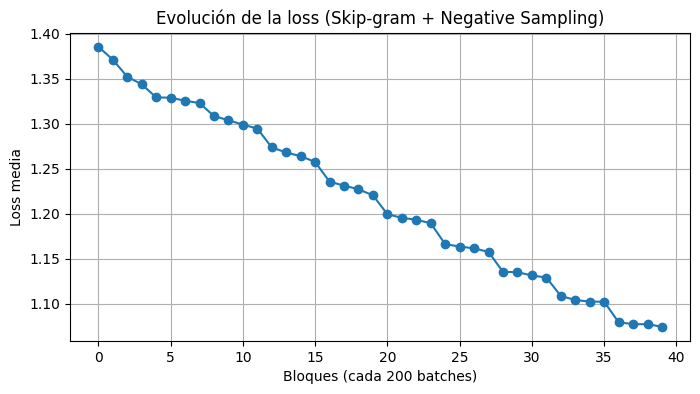

In [55]:
plt.figure(figsize=(8, 4))
plt.plot(loss_history, marker="o")
plt.xlabel("Bloques (cada 200 batches)")
plt.ylabel("Loss media")
plt.title("Evolución de la loss (Skip-gram + Negative Sampling)")
plt.grid(True)
plt.show()

## ABRIR INTERFAZ MLFLOW

In [26]:
print("Tracking URI:", mlflow.get_tracking_uri())

Tracking URI: sqlite:////Volumes/SSD_ROQUE/proyectos didacticos/word2vec /mlflow_local/mlruns.db


- mlflow ui --backend-store-uri "sqlite:////Volumes/SSD_ROQUE/proyectos didacticos/word2vec /mlflow_local/mlruns.db"
- http://127.0.0.1:5000 

# EVALUAR EMBEDDINGS

In [56]:
# =========================
# EVALUAR EMBEDDINGS
# =========================

# model.in_embed.weight es la matriz de embeddings "de entrada" (in_embed).
# Forma: (V, D)
#   V = tamaño del vocabulario
#   D = dimensión del embedding (embed_dim)
#
# detach() -> crea un tensor "desconectado" del grafo de autograd:
#            ya no guarda información para gradientes (no hace falta para evaluar).
# cpu()     -> lo mueve a CPU para calcular similitudes cómodamente.
W = model.in_embed.weight.detach().cpu()

# Normalizamos cada fila del embedding (cada palabra) para que tenga norma 1.
# F.normalize(W, dim=1) divide cada vector por su norma L2:
#   W[i] := W[i] / ||W[i]||
#
# ¿Por qué?
# Porque así el producto escalar (dot product) entre dos filas normalizadas
# equivale a la similitud coseno:
#   cos_sim(a,b) = (a·b) / (||a|| ||b||)
# Si ||a||=||b||=1 => cos_sim(a,b) = a·b
W = F.normalize(W, dim=1)


def most_similar(word, word2idx, idx2word, W, topk=10):
    """
    Devuelve las 'topk' palabras más similares a 'word' según similitud coseno.

    Parámetros:
      - word: string, palabra consulta (ej. "king")
      - word2idx: dict {palabra -> id}
      - idx2word: dict {id -> palabra}
      - W: tensor (V, D) con embeddings normalizados (norma 1 por fila)
      - topk: cuántas palabras devolver (sin contar la propia palabra)

    Salida:
      - lista de tuplas (palabra, similitud) ordenada de mayor a menor similitud
    """

    # Si la palabra no está en el vocabulario (p.ej. fue filtrada por min_count),
    # no podemos buscar su embedding.
    if word not in word2idx:
        print("Palabra no en vocab:", word)
        return

    # Convertimos palabra -> índice (id) en el vocabulario.
    i = word2idx[word]

    # W[i] es el embedding (D,) de la palabra consulta.
    # W es (V, D).
    #
    # Producto matricial:
    #   sims = W @ W[i]
    # significa:
    #   para cada palabra j:
    #       sims[j] = W[j] · W[i]
    #
    # Como W está normalizado, esto es:
    #   sims[j] = cos_sim(W[j], W[i])
    #
    # Forma:
    #   sims: (V,)
    sims = W @ W[i]

    # topk devuelve los k valores más grandes y sus índices.
    # Pedimos topk+1 porque el más similar normalmente será la palabra consigo misma
    # (similitud = 1.0), y luego la excluiremos.
    #
    # vals: (topk+1,)  -> similitudes
    # idxs: (topk+1,)  -> ids de palabras correspondientes
    vals, idxs = torch.topk(sims, k=topk+1)

    out = []

    # Convertimos tensores a listas Python para iterar y guardar resultados.
    # Recorremos parejas (similitud, índice).
    for v, j in zip(vals.tolist(), idxs.tolist()):

        # Excluimos la propia palabra (id i), porque siempre saldría como la más similar.
        if j == i:
            continue

        # Guardamos (palabra, similitud).
        out.append((idx2word[j], v))

        # Paramos cuando ya tenemos topk resultados (porque pedimos topk+1).
        if len(out) == topk:
            break

    return out


# prueba
most_similar("man", word2idx, idx2word, W, topk=10)

[('robot', 0.6344495415687561),
 ('begs', 0.6250552535057068),
 ('famicom', 0.6210263967514038),
 ('mega', 0.6139653921127319),
 ('tessic', 0.6078504323959351),
 ('motherhood', 0.6074358224868774),
 ('natasha', 0.6064437031745911),
 ('goldberg', 0.6050922870635986),
 ('wily', 0.6027864813804626),
 ('seems', 0.6005766987800598)]

In [57]:
# EVALUAR EMBEDDINGS

W = model.in_embed.weight.detach().cpu()
W = F.normalize(W, dim=1)

def most_similar(word, word2idx, idx2word, W, topk=10):
    if word not in word2idx:
        print("Palabra no en vocab:", word)
        return
    i = word2idx[word]
    sims = W @ W[i]
    vals, idxs = torch.topk(sims, k=topk+1)
    out = []
    for v, j in zip(vals.tolist(), idxs.tolist()):
        if j == i:
            continue
        out.append((idx2word[j], v))
        if len(out) == topk:
            break
    return out

# prueba
most_similar("same", word2idx, idx2word, W, topk=10)

[('acyclic', 0.5727521181106567),
 ('orientation', 0.4734245538711548),
 ('close', 0.46945250034332275),
 ('strings', 0.46288955211639404),
 ('vertices', 0.4578620493412018),
 ('graph', 0.4532970190048218),
 ('reachability', 0.4525652229785919),
 ('triangles', 0.4466736316680908),
 ('dag', 0.4407592713832855),
 ('coded', 0.439358115196228)]

In [58]:

# embeddings normalizados
# W: (V, D)
# word2idx, idx2word

def analogy(a, b, c, word2idx, idx2word, W, topk=10):
    """
    Resuelve analogías del tipo:
      a - b + c ≈ ?

    Ejemplo:
      analogy("king", "queen", "man") -> woman
    """

    for w in (a, b, c):
        if w not in word2idx:
            print("Palabra no en vocab:", w)
            return

    va = W[word2idx[a]]
    vb = W[word2idx[b]]
    vc = W[word2idx[c]]

    # vector resultado
    v = va - vb + vc

    # normalizamos para usar coseno
    v = F.normalize(v, dim=0)

    # similitudes coseno con todo el vocabulario
    sims = W @ v

    # excluimos las palabras de entrada
    for w in (a, b, c):
        sims[word2idx[w]] = -1e9

    vals, idxs = torch.topk(sims, k=topk)

    return [(idx2word[i], s) for i, s in zip(idxs.tolist(), vals.tolist())]

In [59]:
analogy("king", "queen", "man", word2idx, idx2word, W, topk=10)

[('mann', 0.5961196422576904),
 ('echmarcach', 0.5492823123931885),
 ('gall', 0.5381312966346741),
 ('gofraid', 0.5376471281051636),
 ('paternal', 0.5337356328964233),
 ('diarmait', 0.5322129726409912),
 ('claimant', 0.5277270078659058),
 ('speak', 0.5088396072387695),
 ('immortality', 0.5083117485046387),
 ('mac', 0.5072265267372131)]

In [60]:
most_similar("woman", word2idx, idx2word, W, topk=10)

[('immortality', 0.7373651266098022),
 ('lsd', 0.7321130633354187),
 ('homosexuality', 0.7300300002098083),
 ('sad', 0.7282736897468567),
 ('greatness', 0.7282096147537231),
 ('reminds', 0.7279955148696899),
 ('opines', 0.7265403270721436),
 ('likeable', 0.7256742119789124),
 ('melancholic', 0.7231278419494629),
 ('describing', 0.7221732139587402)]

# COMPARACION VISUAL

## 2D

In [61]:
W = model.in_embed.weight.detach().cpu()   # (V, D)
W = F.normalize(W, dim=1)                  # normaliza filas (coseno)

def most_similar_words(word, word2idx, idx2word, W, topk=15):
    if word not in word2idx:
        print("No en vocab:", word)
        return []
    i = word2idx[word]
    sims = (W @ W[i]).numpy()
    sims[i] = -1e9
    idxs = np.argpartition(-sims, range(topk))[:topk]
    idxs = idxs[np.argsort(-sims[idxs])]
    return [idx2word[j] for j in idxs]

target = "queen"   # cambia esto por la palabra que quieras
words = [target] + most_similar_words(target, word2idx, idx2word, W, topk=15)
words

['queen',
 'consort',
 'villiers',
 'roundabout',
 'champagne',
 'dudley',
 'northumberland',
 'gate',
 'montagne',
 'hailing',
 'coronation',
 'buckingham',
 'copied',
 'lamby',
 'aurangzeb',
 'rover']

In [62]:
from sklearn.decomposition import PCA

# matriz (N, D) con los embeddings de esas palabras
X = np.stack([W[word2idx[w]].numpy() for w in words], axis=0)

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)   # (N, 2)

Z.shape, pca.explained_variance_ratio_

((16, 2), array([0.30122584, 0.13012892], dtype=float32))

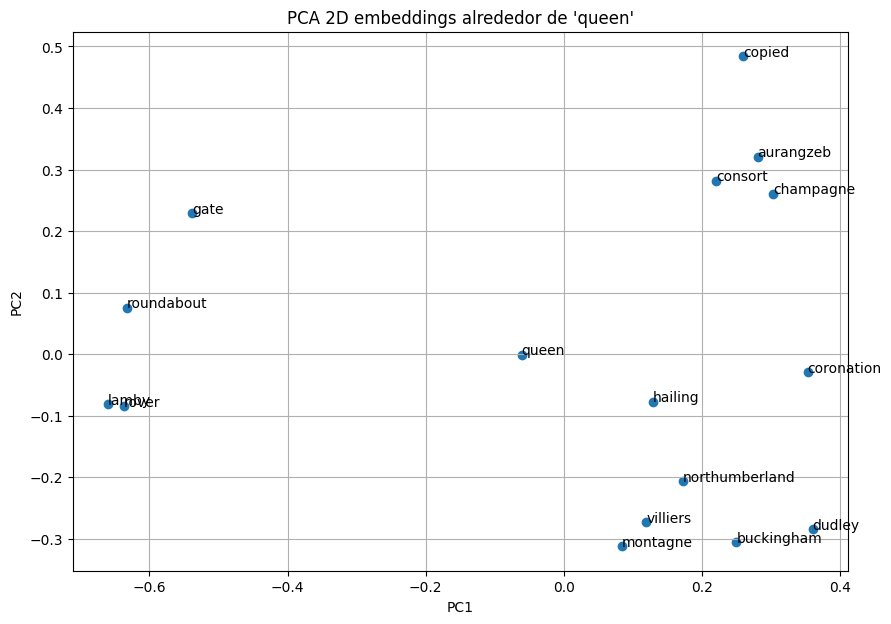

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(Z[:,0], Z[:,1])

for (x, y), w in zip(Z, words):
    plt.text(x, y, w, fontsize=10)

plt.title(f"PCA 2D embeddings alrededor de '{target}'")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [133]:
def analogy_vector(a, b, c, word2idx, W):
    """
    Devuelve el vector normalizado:
        v = a - b + c
    """
    va = W[word2idx[a]].numpy()
    vb = W[word2idx[b]].numpy()
    vc = W[word2idx[c]].numpy()

    v = va - vb + vc
    v = v / (np.linalg.norm(v) + 1e-12)  # normalizar

    return v

v_analogy = analogy_vector("man", "woman", "queen", word2idx, W)

In [134]:
words = ["man", "woman", "queen", "king"]

# comprobación de vocabulario
for w in words:
    assert w in word2idx, f"{w} no está en el vocabulario"

# embeddings reales
X_words = np.stack([W[word2idx[w]].numpy() for w in words], axis=0)

# añadimos el vector de analogía al final
X = np.vstack([X_words, v_analogy[None, :]])
#X = X_words

labels = words + ["man - woman + queen"]

In [135]:
pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)   # (5, 2)

Z

array([[ 0.2825781 ,  0.62227243],
       [ 0.74139684, -0.04520517],
       [-0.44195786, -0.27872425],
       [ 0.10372867, -0.59545606],
       [-0.68574566,  0.29711297]], dtype=float32)

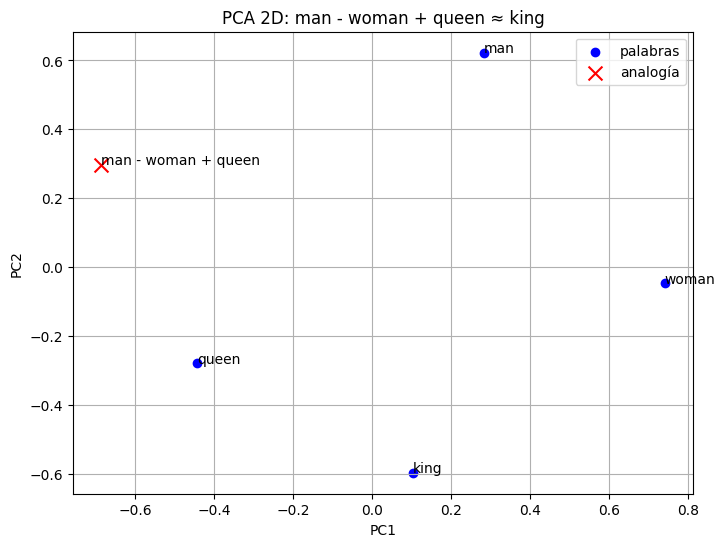

In [139]:
plt.figure(figsize=(8, 6))

# palabras reales
plt.scatter(Z[:4, 0], Z[:4, 1], c="blue", label="palabras")
#plt.scatter(Z[:, 0], Z[:, 1], c="blue", label="palabras")
# vector de analogía

# x_analogy = -(Z[0,0]-Z[1,0]-Z[2,0])
# y_analogy = -(Z[0,1]-Z[1,1]-Z[2,1])
# plt.scatter(x_analogy, y_analogy, c="red", marker="x", s=100, label="analogía")
plt.scatter(Z[4, 0], Z[4, 1], c="red", marker="x", s=100, label="analogía")


for (x, y), label in zip(Z, labels):
    plt.text(x, y, label, fontsize=10)

plt.title("PCA 2D: man - woman + queen ≈ king")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

## DIRECCION DE GÉNERO

In [75]:
pairs = [
    ("man", "woman"),
    ("king", "queen"),
    ("boy", "girl"),
    ("he", "she"),
    ("father", "mother"),
    ("son", "daughter"),
    ("husband", "wife"),
]
pairs = [(m,f) for m,f in pairs if m in word2idx and f in word2idx]
pairs

[('man', 'woman'),
 ('king', 'queen'),
 ('boy', 'girl'),
 ('he', 'she'),
 ('father', 'mother'),
 ('son', 'daughter'),
 ('husband', 'wife')]

In [76]:
def unit(x):
    return x / (np.linalg.norm(x) + 1e-12)

diffs = []
for m, f in pairs:
    vm = W[word2idx[m]].numpy()
    vf = W[word2idx[f]].numpy()
    diffs.append(unit(vf - vm))   # normalizamos cada diferencia

gender_dir = unit(np.mean(diffs, axis=0))  # vector unitario final

In [77]:
words = list({w for pair in pairs for w in pair})
# añade algunas extra si quieres
extras = ["doctor","nurse","engineer","teacher","scientist","actress","actor"]
words += [w for w in extras if w in word2idx]
words = sorted(set(words))

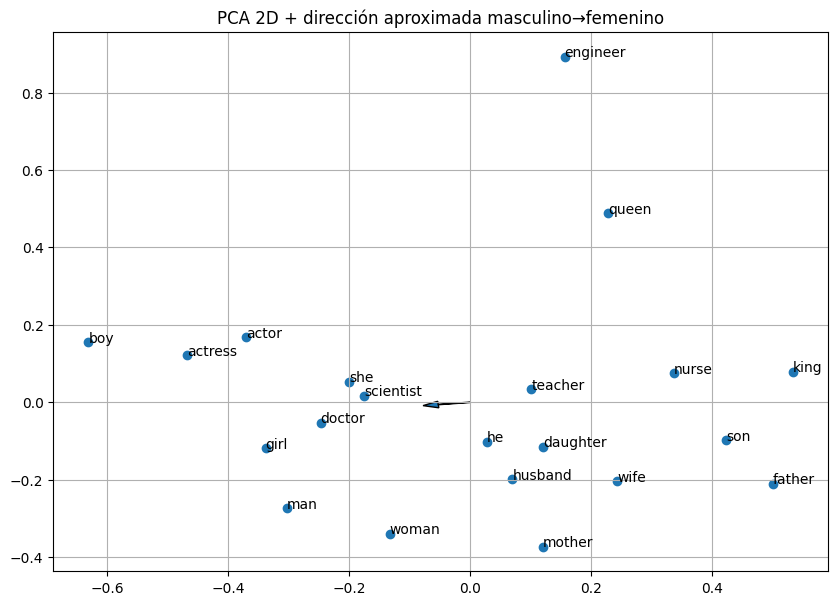

In [78]:
X = np.stack([W[word2idx[w]].numpy() for w in words], axis=0)

pca = PCA(n_components=2, random_state=0)
Z = pca.fit_transform(X)

plt.figure(figsize=(10,7))
plt.scatter(Z[:,0], Z[:,1])

for (x,y), w in zip(Z, words):
    plt.text(x, y, w, fontsize=10)

# Proyectar la dirección gender_dir al espacio PCA 2D:
# Si Z = (X - mean) @ components.T, entonces dir_2d = gender_dir @ components.T
dir2d = gender_dir @ pca.components_.T   # (2,)

# Dibujar flecha desde el centro del gráfico
center = Z.mean(axis=0)
scale = np.linalg.norm(Z.std(axis=0)) * 0.8  # escala visual (ajustable)
arrow_end = center + dir2d * scale

plt.arrow(center[0], center[1], (arrow_end-center)[0], (arrow_end-center)[1],
          length_includes_head=True, head_width=0.05*scale)

plt.title("PCA 2D + dirección aproximada masculino→femenino")
plt.grid(True)
plt.show()

## 3D

In [79]:
pairs = [
    ("man", "woman"),
    ("king", "queen"),
    ("boy", "girl"),
    ("he", "she"),
    ("father", "mother"),
]

# Filtra pares que existan en tu vocabulario
pairs_ok = [(m,f) for (m,f) in pairs if m in word2idx and f in word2idx]
pairs_ok

[('man', 'woman'),
 ('king', 'queen'),
 ('boy', 'girl'),
 ('he', 'she'),
 ('father', 'mother')]

In [80]:
# Embeddings normalizados (si ya lo tienes, no pasa nada por repetir)
W = model.in_embed.weight.detach().cpu()
W = F.normalize(W, dim=1)

# Lista de palabras a plotear (las 10 de las 5 parejas)
words = []
for m, f in pairs_ok:
    words.extend([m, f])
words = list(dict.fromkeys(words))  # mantiene orden y quita duplicados

# Matriz X (N, D)
X = np.stack([W[word2idx[w]].numpy() for w in words], axis=0)

# PCA 3D
pca = PCA(n_components=3, random_state=0)
Z = pca.fit_transform(X)  # (N, 3)

# Dirección masculino→femenino promedio (en espacio original) y proyectada a PCA
def unit(v): 
    return v / (np.linalg.norm(v) + 1e-12)

diffs = []
for m, f in pairs_ok:
    vm = W[word2idx[m]].numpy()
    vf = W[word2idx[f]].numpy()
    diffs.append(unit(vf - vm))

gender_dir = unit(np.mean(diffs, axis=0))        # (D,)
gender_dir_3d = gender_dir @ pca.components_.T    # (3,)

Z.shape, gender_dir_3d

((10, 3), array([-0.31792095,  0.230611  ,  0.58737326], dtype=float32))

In [81]:
# Colores por rol (masc/fem)
role = {}
for m, f in pairs_ok:
    role[m] = "male"
    role[f] = "female"

colors = ["royalblue" if role.get(w)=="male" else "crimson" for w in words]

fig = go.Figure()

# Puntos 3D
fig.add_trace(go.Scatter3d(
    x=Z[:,0], y=Z[:,1], z=Z[:,2],
    mode="markers+text",
    text=words,
    textposition="top center",
    marker=dict(size=6, color=colors),
    hovertext=[f"{w} ({role.get(w,'')})" for w in words],
    hoverinfo="text"
))

# Flechas por pareja (líneas mascul→femen)
word_to_xyz = {w: Z[i] for i, w in enumerate(words)}
for m, f in pairs_ok:
    p0 = word_to_xyz[m]
    p1 = word_to_xyz[f]
    fig.add_trace(go.Scatter3d(
        x=[p0[0], p1[0]],
        y=[p0[1], p1[1]],
        z=[p0[2], p1[2]],
        mode="lines",
        line=dict(width=5),
        hoverinfo="skip",
        showlegend=False
    ))

# Flecha global masculino→femenino desde el centro del cloud
center = Z.mean(axis=0)
scale = float(np.linalg.norm(Z.std(axis=0)) * 1.2)  # ajusta tamaño visual
end = center + unit(gender_dir_3d) * scale

fig.add_trace(go.Scatter3d(
    x=[center[0], end[0]],
    y=[center[1], end[1]],
    z=[center[2], end[2]],
    mode="lines",
    line=dict(width=10, dash="dash"),
    name="Dirección promedio masc→fem",
    hoverinfo="skip"
))

fig.update_layout(
    title="PCA 3D interactivo: pares masculino/femenino + dirección promedio",
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
    ),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()

In [82]:
pairs = [
    ("man", "men"),
    ("woman", "women"),
    ("dog", "dogs"),
    ("cat", "cats"),
    ("person", "people"),
]

# Filtra pares que existan en tu vocabulario
pairs_ok = [(m,f) for (m,f) in pairs if m in word2idx and f in word2idx]
pairs_ok

[('man', 'men'),
 ('woman', 'women'),
 ('dog', 'dogs'),
 ('cat', 'cats'),
 ('person', 'people')]

In [83]:
# Embeddings normalizados (si ya lo tienes, no pasa nada por repetir)
W = model.in_embed.weight.detach().cpu()
W = F.normalize(W, dim=1)

# Lista de palabras a plotear (las 10 de las 5 parejas)
words = []
for m, f in pairs_ok:
    words.extend([m, f])
words = list(dict.fromkeys(words))  # mantiene orden y quita duplicados

# Matriz X (N, D)
X = np.stack([W[word2idx[w]].numpy() for w in words], axis=0)

# PCA 3D
pca = PCA(n_components=3, random_state=0)
Z = pca.fit_transform(X)  # (N, 3)

# Dirección masculino→femenino promedio (en espacio original) y proyectada a PCA
def unit(v): 
    return v / (np.linalg.norm(v) + 1e-12)

diffs = []
for m, f in pairs_ok:
    vm = W[word2idx[m]].numpy()
    vf = W[word2idx[f]].numpy()
    diffs.append(unit(vf - vm))

gender_dir = unit(np.mean(diffs, axis=0))        # (D,)
gender_dir_3d = gender_dir @ pca.components_.T    # (3,)

Z.shape, gender_dir_3d

((10, 3), array([0.68718034, 0.52950794, 0.09844208], dtype=float32))

In [84]:
# Colores por rol (masc/fem)
role = {}
for m, f in pairs_ok:
    role[m] = "male"
    role[f] = "female"

colors = ["royalblue" if role.get(w)=="male" else "crimson" for w in words]

fig = go.Figure()

# Puntos 3D
fig.add_trace(go.Scatter3d(
    x=Z[:,0], y=Z[:,1], z=Z[:,2],
    mode="markers+text",
    text=words,
    textposition="top center",
    marker=dict(size=6, color=colors),
    hovertext=[f"{w} ({role.get(w,'')})" for w in words],
    hoverinfo="text"
))

# Flechas por pareja (líneas mascul→femen)
word_to_xyz = {w: Z[i] for i, w in enumerate(words)}
for m, f in pairs_ok:
    p0 = word_to_xyz[m]
    p1 = word_to_xyz[f]
    fig.add_trace(go.Scatter3d(
        x=[p0[0], p1[0]],
        y=[p0[1], p1[1]],
        z=[p0[2], p1[2]],
        mode="lines",
        line=dict(width=5),
        hoverinfo="skip",
        showlegend=False
    ))

# Flecha global masculino→femenino desde el centro del cloud
center = Z.mean(axis=0)
scale = float(np.linalg.norm(Z.std(axis=0)) * 1.2)  # ajusta tamaño visual
end = center + unit(gender_dir_3d) * scale

fig.add_trace(go.Scatter3d(
    x=[center[0], end[0]],
    y=[center[1], end[1]],
    z=[center[2], end[2]],
    mode="lines",
    line=dict(width=10, dash="dash"),
    name="Dirección promedio masc→fem",
    hoverinfo="skip"
))

fig.update_layout(
    title="PCA 3D interactivo: pares masculino/femenino + dirección promedio",
    scene=dict(
        xaxis_title="PC1",
        yaxis_title="PC2",
        zaxis_title="PC3",
    ),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()

In [85]:

# =========================
# Embeddings normalizados
# =========================
W = model.in_embed.weight.detach().cpu()
W = F.normalize(W, dim=1)

def unit(v):
    return v / (np.linalg.norm(v) + 1e-12)

# =========================
# Categorías de pares
# =========================
# PAIR_SETS = {
#     "Profesion -> Lugar": [
#         ("doctor", "hospital"),
#         ("teacher", "school"),
#         ("judge", "court"),
#         ("chef", "kitchen"),
#         ("pilot", "airplane"),
#     ],
#     "Tamano / Intensidad (opuestos)": [
#         ("big", "small"),
#         ("high", "low"),
#         ("hot", "cold"),
#         ("strong", "weak"),
#         ("fast", "slow"),
#     ],
#     "Capital -> Pais": [
#         ("paris", "france"),
#         ("berlin", "germany"),
#         ("rome", "italy"),
#         ("madrid", "spain"),
#         ("london", "britain"),  # a veces aparece como "uk" o "england"
#     ],
#     "Pais -> Nacionalidad": [
#         ("spain", "spanish"),
#         ("france", "french"),
#         ("germany", "german"),
#         ("italy", "italian"),
#         ("japan", "japanese"),
#     ],
#     "Comparativo / Superlativo": [
#         ("big", "bigger"),
#         ("small", "smaller"),
#         ("fast", "faster"),
#         ("good", "better"),
#         ("bad", "worse"),
#     ],
#     "Presente -> Pasado": [
#         ("walk", "walked"),
#         ("play", "played"),
#         ("run", "ran"),
#         ("go", "went"),
#         ("see", "saw"),
#     ],
#     "Relaciones semanticas abstractas": [
#         ("war", "peace"),
#         ("crime", "punishment"),
#         ("knowledge", "power"),
#         ("money", "rich"),
#         ("poverty", "poor"),
#     ],
# }

PAIR_SETS = groups

# =========================
# Visualización por categoría
# =========================
def plot_pairs_3d(category_name, pairs):
    # Filtra pares que existan en el vocabulario
    pairs_ok = [(a, b) for (a, b) in pairs if a in word2idx and b in word2idx]

    print(f"\n=== {category_name} ===")
    print(f"Pares propuestos: {len(pairs)} | Pares en vocab: {len(pairs_ok)}")
    if len(pairs_ok) < 2:
        print("⚠️ Muy pocos pares en vocab para una visualización útil. Prueba otras palabras/categoría.")
        return

    # Lista de palabras a plotear (2 por par)
    words = []
    for a, b in pairs_ok:
        words.extend([a, b])
    words = list(dict.fromkeys(words))  # mantiene orden y quita duplicados

    # Matriz X (N, D)
    X = np.stack([W[word2idx[w]].numpy() for w in words], axis=0)

    # PCA 3D
    pca = PCA(n_components=3, random_state=0)
    Z = pca.fit_transform(X)  # (N, 3)

    # Dirección promedio de la relación (b - a) para esta categoría
    diffs = []
    for a, b in pairs_ok:
        va = W[word2idx[a]].numpy()
        vb = W[word2idx[b]].numpy()
        diffs.append(unit(vb - va))
    rel_dir = unit(np.mean(diffs, axis=0))           # (D,)
    rel_dir_3d = rel_dir @ pca.components_.T         # (3,)

    # Roles para colorear (A vs B)
    role = {}
    for a, b in pairs_ok:
        role[a] = "A"
        role[b] = "B"

    colors = ["royalblue" if role.get(w) == "A" else "crimson" for w in words]

    fig = go.Figure()

    # Puntos 3D
    fig.add_trace(go.Scatter3d(
        x=Z[:, 0], y=Z[:, 1], z=Z[:, 2],
        mode="markers+text",
        text=words,
        textposition="top center",
        marker=dict(size=6, color=colors),
        hovertext=[f"{w} ({role.get(w,'')})" for w in words],
        hoverinfo="text",
        name="palabras"
    ))

    # Líneas por pareja (A -> B)
    word_to_xyz = {w: Z[i] for i, w in enumerate(words)}
    for a, b in pairs_ok:
        p0 = word_to_xyz[a]
        p1 = word_to_xyz[b]
        fig.add_trace(go.Scatter3d(
            x=[p0[0], p1[0]],
            y=[p0[1], p1[1]],
            z=[p0[2], p1[2]],
            mode="lines",
            line=dict(width=5),
            hoverinfo="skip",
            showlegend=False
        ))

    # Flecha global de la relación desde el centro del cloud
    center = Z.mean(axis=0)
    scale = float(np.linalg.norm(Z.std(axis=0)) * 1.2)
    end = center + unit(rel_dir_3d) * scale

    fig.add_trace(go.Scatter3d(
        x=[center[0], end[0]],
        y=[center[1], end[1]],
        z=[center[2], end[2]],
        mode="lines",
        line=dict(width=10, dash="dash"),
        name=f"Dir promedio: {category_name}",
        hoverinfo="skip"
    ))

    fig.update_layout(
        title=f"PCA 3D interactivo: {category_name}",
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3",
        ),
        margin=dict(l=0, r=0, t=50, b=0)
    )
    fig.show()


# =========================
# Bucle con stop por categoría
# =========================
for name, pairs in PAIR_SETS.items():
    plot_pairs_3d(name, pairs)
    input("Pulsa ENTER para pasar a la siguiente categoría...")


=== gender ===
Pares propuestos: 5 | Pares en vocab: 5



=== plural ===
Pares propuestos: 5 | Pares en vocab: 5



=== tense ===
Pares propuestos: 5 | Pares en vocab: 5



=== comp_super ===
Pares propuestos: 5 | Pares en vocab: 5



=== country_capital ===
Pares propuestos: 5 | Pares en vocab: 5


# CARGAR EL MODELO GUARDADO 

In [ ]:
# GUIA PARA CARGAR EL MODELO 

# ---------- RUTAS ----------
MODEL_PATH = "model_state.pt"
VOCAB_PATH = "vocab.json"
CONFIG_PATH = "config.json"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- CARGAR CONFIG ----------
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)

vocab_size = config["vocab_size"]
embed_dim = config["embed_dim"]

# ---------- DEFINIR MODELO (MISMA ARQUITECTURA) ----------
model = SkipGramNeg(vocab_size, embed_dim).to(device)

# ---------- CARGAR PESOS ----------
state_dict = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state_dict)
model.eval()

# ---------- CARGAR VOCABULARIO ----------
with open(VOCAB_PATH, "r") as f:
    word2idx = json.load(f)

idx2word = {i: w for w, i in word2idx.items()}

# ---------- EXTRAER EMBEDDINGS ----------
W = model.in_embed.weight.detach().cpu()
W = F.normalize(W, dim=1)

print("Modelo y embeddings cargados correctamente")
print("Vocab size:", W.shape[0])
print("Embedding dim:", W.shape[1])

FileNotFoundError: [Errno 2] No such file or directory: 'vocab.json'